#Прогнозирование температуры звёзд

In [ ]:
!pip install torch==1.10.0+cpu torchvision==0.11.0+cpu torchaudio==0.10.0 -f https://download.pytorch.org/whl/torch_stable.html --user

import pandas as pd

import numpy as np

import random

import torch
import torch.nn as nn

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer

from math import ceil

from skorch import NeuralNetBinaryClassifier
from skorch import NeuralNetRegressor
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV

from math import sqrt

from sklearn.metrics import make_scorer

from sklearn.datasets import make_classification

## Загрузка данных

In [ ]:
df = pd.read_csv('/datasets/6_class.csv')
df.sample(10)

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
150,150,29560,188000.000000,6.0200,-4.01,3,Blue-white
184,184,3453,0.000621,0.0773,17.08,0,Red
179,179,24490,248490.000000,1134.5000,-8.24,5,Blue-white
217,217,19400,10920.000000,6.0300,-3.08,3,Blue-white
151,151,8945,38.000000,2.4870,0.12,3,Blue-White
117,117,3625,74000.000000,876.0000,-10.25,5,Red
123,123,3146,0.000150,0.0932,16.92,0,Red
51,51,3750,283000.000000,1260.0000,-7.63,5,Red
176,176,18000,200000.000000,1045.0000,-8.30,5,Blue
186,186,2968,0.000461,0.1190,17.45,0,Red


## Анализ данных

In [ ]:
#Подсчитаем и удалим полные дубликаты из таблицы
df.duplicated().sum()

0

In [ ]:
#Проверим число пропусков в столбцах
pd.DataFrame(round(df.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
Unnamed: 0,0.000000
Temperature (K),0.000000
Luminosity(L/Lo),0.000000
Radius(R/Ro),0.000000
Absolute magnitude(Mv),0.000000
Star type,0.000000
Star color,0.000000


In [ ]:
#Проверим типы данных в столбцах
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


In [ ]:
#Изучим общюю информацию по распределению данных в таблице числовых данных
df.describe()

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.00000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,119.50000,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,69.42622,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,0.00000,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,59.75000,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,119.50000,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,179.25000,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,239.00000,40000.000000,849420.000000,1948.500000,20.060000,5.000000


In [ ]:
#Проверим типы данных в столбцах
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


Изучим каждый признак более подробно

In [ ]:
df['Star color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

In [ ]:
df['Star type'].unique()
df.groupby(['Star type']).agg('count')['Unnamed: 0']

Star type
0    40
1    40
2    40
3    40
4    40
5    40
Name: Unnamed: 0, dtype: int64

In [ ]:
# Создадим небольшую функцию для анализа данных в столбцах с числовыми значениями
def draw_distribution(df, x, x_label, y_label, title, bins):
    plt.figure(figsize=(12, 8))
    sns.histplot(data=df, x=x, kde=True, bins=bins)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

    plt.figure(figsize=(12, 8))
    sns.boxplot(data=df, x=x)
    plt.title(title)
    plt.xlabel(x_label)
    plt.show()

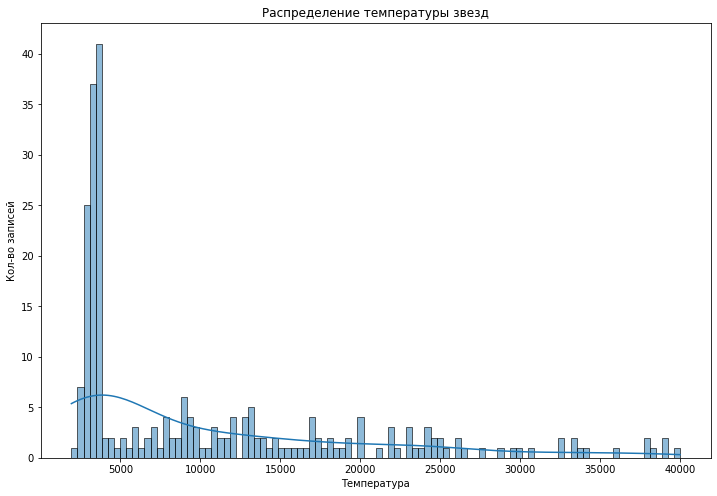

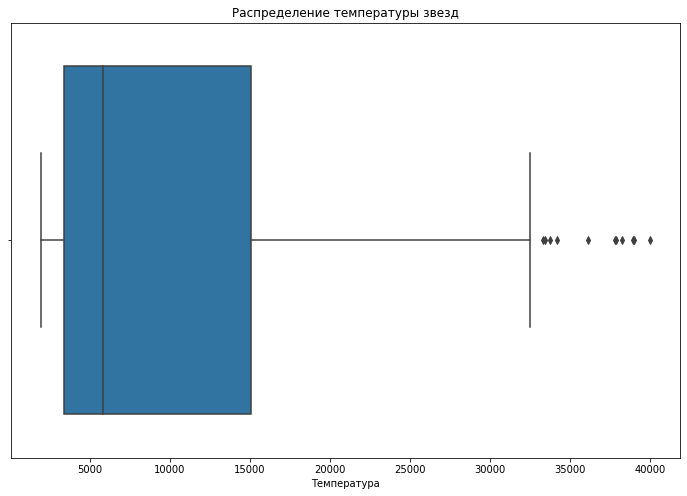

In [ ]:
draw_distribution(df, 'Temperature (K)', 'Температура', 'Кол-во записей', 'Распределение температуры звезд', 100)

In [ ]:
df.loc[df['Temperature (K)'] > 34000].count()['Temperature (K)']

8

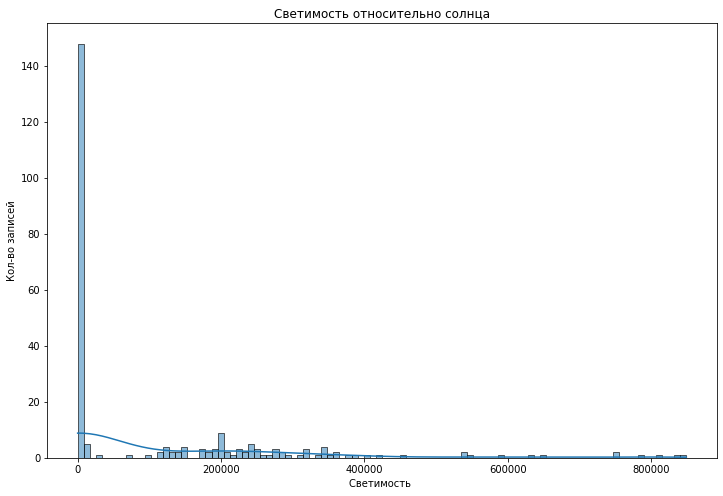

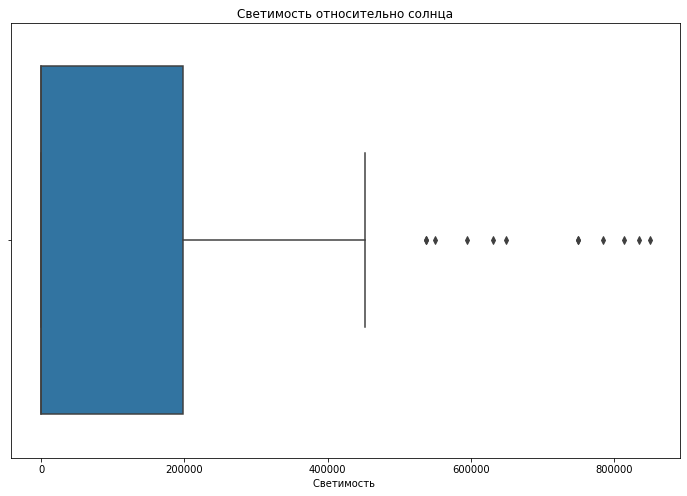

In [ ]:
draw_distribution(df, 'Luminosity(L/Lo)', 'Светимость ', 'Кол-во записей', 'Светимость относительно солнца', 100)

In [ ]:
df.loc[df['Luminosity(L/Lo)'] > 460000].count()['Temperature (K)']

12

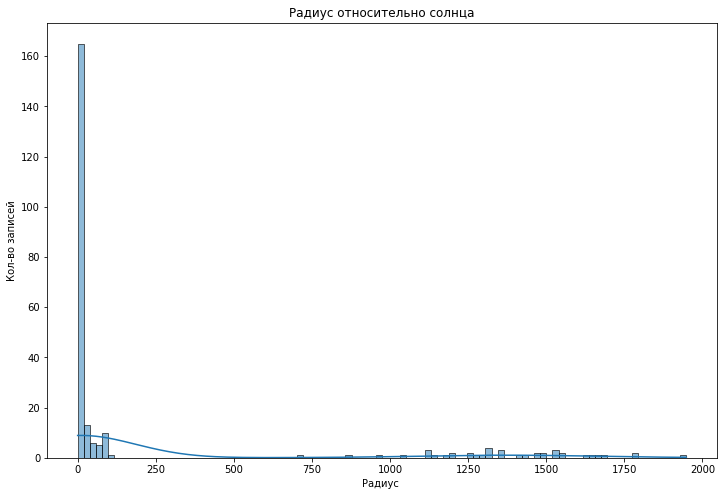

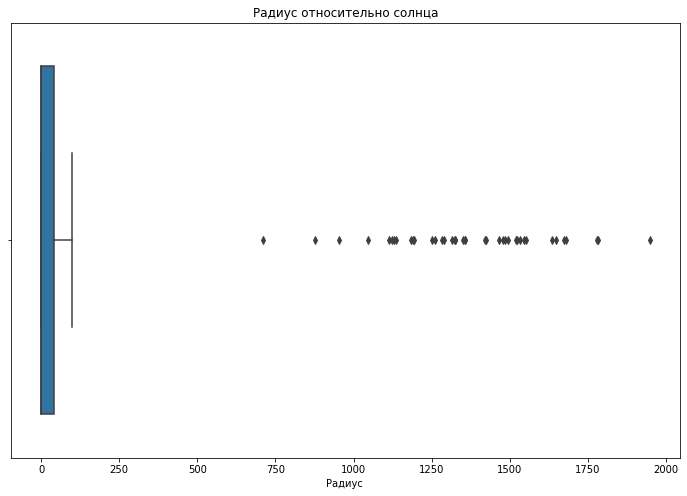

In [ ]:
draw_distribution(df, 'Radius(R/Ro)', 'Радиус ', 'Кол-во записей', 'Радиус относительно солнца', 100)

In [ ]:
df.loc[df['Radius(R/Ro)'] > 500].count()['Temperature (K)']

40

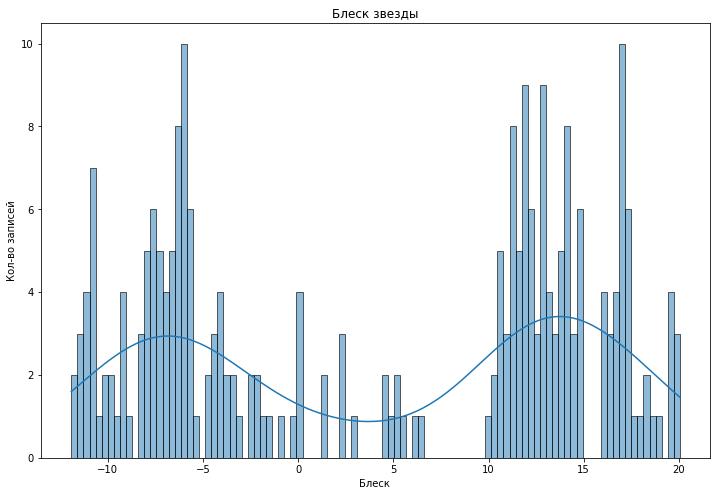

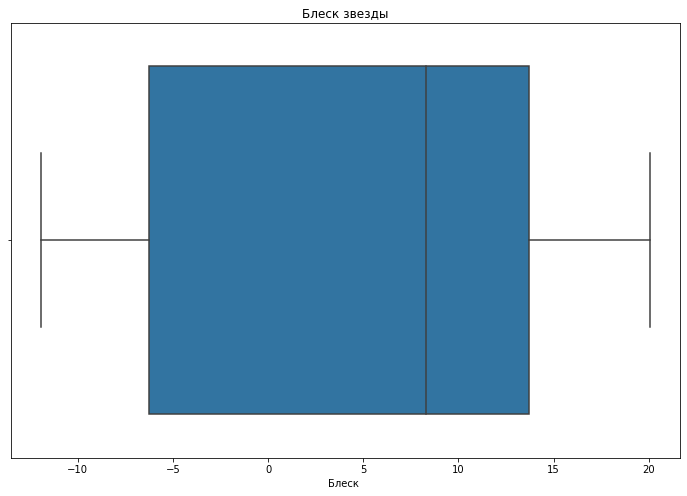

In [ ]:
draw_distribution(df, 'Absolute magnitude(Mv)', 'Блеск ', 'Кол-во записей', 'Блеск звезды', 100)

Выводы:

1. В столбце Star color присутвует ряд неявных дубликатов- Blue white, Blue White, Blue-white, Blue white , Blue , Blue, Blue-White, White, white, yellowish, yellowish, yellow-white, White-Yellow
2. Согласно столбцу 'Star type' нам дано ровно по 40 записей каждого из видов звезды
3. В столбцах: Temperature (K) и 'Luminosity(L/Lo)' присутвует ряд выбросов, их довольно немного, удалим их. В столбце- 'Radius(R/Ro)' также присутвует ряд выбросов, однако их мы не будем удалять из-за довольно большого их колличества, а также поскольку нам досконально неизвестна их природа, есть риск потери важных данных.

## Предобработка данных

In [ ]:
# заменим наименования столбцов для удобства
df = df.rename(columns={'Temperature (K)': 'Temperature',
                        'Luminosity(L/Lo)': 'Luminosity',
                        'Radius(R/Ro)': 'Radius',
                        'Absolute magnitude(Mv)': 'Absolute_magnitude',
                        'Star type': 'Star_type',
                        'Star color': 'Star_color'})

In [ ]:
# Столбец 'Unnamed: 0' уберем как лишний, он по сути дублирует столбец с индексами и не нужен нам
df = df.drop(['Unnamed: 0'], axis=1)

In [ ]:
#Заменим неявные дубликаты, выявленные на предыдущем шаге
df['Star_color'] = df['Star_color'].str.lower()
df['Star_color'] = df['Star_color'].str.strip()
df['Star_color'] = df['Star_color'].replace(['yellow-white'],'white yellow')
df['Star_color'] = df['Star_color'].replace(['white-yellow'],'white yellow')
df['Star_color'] = df['Star_color'].replace(['blue-white'],'blue white')
df.groupby(['Star_color']).agg('count')['Luminosity']

Star_color
blue                   56
blue white             41
orange                  2
orange-red              1
pale yellow orange      1
red                   112
white                  10
white yellow            9
whitish                 2
yellowish               3
yellowish white         3
Name: Luminosity, dtype: int64

In [ ]:
#Объеденим значения из столбца Star_color по которым у нас есть не более 2-3 значений с другими признаками
df['Star_color'] = df['Star_color'].replace(['yellowish white'],'white yellow')
df['Star_color'] = df['Star_color'].replace(['whitish'],'white')
df['Star_color'] = df['Star_color'].replace(['orange-red'],'red')
df['Star_color'] = df['Star_color'].replace(['pale yellow orange'],'red')
df['Star_color'] = df['Star_color'].replace(['yellowish'],'white yellow')
df['Star_color'] = df['Star_color'].replace(['orange'],'red')
df.groupby(['Star_color']).agg('count')['Luminosity']

Star_color
blue             56
blue white       41
red             116
white            12
white yellow     15
Name: Luminosity, dtype: int64

In [ ]:
print('Колличество аномальных значений по признаку - Temperature (K) составляет:',
      round(df[df['Temperature'] > 34000].shape[0] / df.shape[0] * 100),'%')
print('Колличество аномальных значений по признаку - Luminosity(L/Lo) составляет:',
      round(df[df['Luminosity'] > 460000].shape[0] / df.shape[0] * 100),'%')

Колличество аномальных значений по признаку - Temperature (K) составляет: 3 %
Колличество аномальных значений по признаку - Luminosity(L/Lo) составляет: 5 %


In [ ]:
df = df.loc[df['Temperature'] < 34000]
df = df.loc[df['Luminosity'] < 460000]
df.describe()

,Temperature,Luminosity,Radius,Absolute_magnitude,Star_type
count,221.000000,221.000000,221.000000,221.000000,221.000000
mean,9146.610860,71061.171006,190.888315,5.406208,2.343891
std,7898.627419,116951.387440,466.857719,10.335936,1.678560
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3324.000000,0.000760,0.097600,-5.920000,1.000000
50%,4015.000000,0.008100,0.460000,10.870000,2.000000
75%,13089.000000,142000.000000,29.000000,14.080000,4.000000
max,33750.000000,452000.000000,1779.000000,20.060000,5.000000


## Построение базовой нейронной сети

In [ ]:
# Разделим выбоку на обучающую и тестовую, используем также и стратификацию выборки, из-за сильного дисбаланса в признаке- Star_color
features = df.drop(['Temperature'], axis=1)
target = df['Temperature']

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=41, shuffle=True, stratify=df['Star_color'])

In [ ]:
# Проведем категоризацию категориальных и масштабирование признаков
var_categorical = ['Star_color', 'Star_type']
var_numeric = ['Radius', 'Luminosity', 'Absolute_magnitude', ]

encoder = OneHotEncoder(handle_unknown='ignore')

features_train_ohe = pd.DataFrame(
        encoder.fit_transform(features_train[var_categorical]).toarray(),
        columns=encoder.get_feature_names()
)


features_valid_ohe = pd.DataFrame(
        encoder.transform(features_valid[var_categorical]).toarray(),
        columns=encoder.get_feature_names()
)


scaler = StandardScaler()

features_train_numeric= pd.DataFrame(
        scaler.fit_transform(features_train[var_numeric]),
        columns=var_numeric
   )

features_valid_numeric= pd.DataFrame(
        scaler.transform(features_valid[var_numeric]),
        columns=var_numeric
   )



features_train = features_train_numeric.join(features_train_ohe)
features_valid = features_valid_numeric.join(features_valid_ohe)


features_train

,Radius,Luminosity,Absolute_magnitude,x0_blue,x0_blue white,x0_red,x0_white,x0_white yellow,x1_0,x1_1,x1_2,x1_3,x1_4,x1_5
0,-0.351755,0.916043,-1.074819,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.427011,-0.638960,1.065741,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,-0.414590,0.949848,-0.852461,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.353851,1.425561,-1.068139,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.421995,-0.638639,-0.458323,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,1.574379,1.127321,-1.542440,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
161,-0.376906,2.948703,-1.041418,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
162,-0.427004,-0.638960,1.145905,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
163,-0.423205,-0.638715,-0.351819,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
X_train = torch.FloatTensor(features_train.values)
X_test = torch.FloatTensor(features_valid.values)
y_train = torch.FloatTensor(target_train.values)
y_test = torch.FloatTensor(target_valid.values)

In [ ]:
len(X_train)
len(y_test)

56

In [ ]:
# Гиперпараметры обучения:
n_in_neurons = X_train.shape[1] # зададим количество нейронов
n_hidden_neurons_1 = 600
n_hidden_neurons_2 = 950
n_out_neurons = 1
num_epochs = 2600 # количество эпох
batch_size = 100
learning_rate = 0.01
num_batches = ceil(len(X_train)/batch_size)


class Net(nn.Module):
    '''
    Класс по созданию нейронной сети
    '''
    def __init__(self, n_features, n, n1, n_out):
        super().__init__()
        self.fc1 = torch.nn.Linear(n_features, n)
        self.fc2 = nn.Linear(n, n1)
        self.fc3 = nn.Linear(n1, n_out)
        self.relu1 = nn.LeakyReLU()
        self.relu2 = nn.LeakyReLU()
        self.relu3 = nn.LeakyReLU(negative_slope=0.7)

    def forward(self, batch):
        batch = self.fc1(batch)
        batch = self.relu1(batch)
        batch = self.fc2(batch)
        batch = self.relu2(batch)
        batch = self.fc3(batch)

        return self.relu3(batch)

net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3) # создаем Adam оптимизатор

loss = nn.MSELoss(reduction='sum') # В качестве функции потерь используем MSE

for epoch in range(num_epochs):
    order = np.random.permutation(len(X_train))
    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size
        optimizer.zero_grad()


    batch_indexes = order[start_index:start_index+batch_size]
    X_batch = X_train[batch_indexes]
    y_batch = y_train[batch_indexes]

    preds = net.forward(X_train).flatten()

    loss_value = loss(preds, y_train)

    loss_value.backward()

    optimizer.step()

    if epoch % 10 == 0 or epoch == num_epochs - 1:
        net.eval()
        test_preds = net.forward(X_test).flatten()
        pred_temp = test_preds.detach().numpy()
        rmse = mean_squared_error(y_test, pred_temp, squared=False)
        print(rmse)

12679.528
12669.555
12645.959
12599.01
12514.556
12374.35
12156.969
11840.23
11405.78
10845.571
10171.427
9421.416
8649.931
7921.141
7309.8203
6861.4634
6569.0376
6389.1035
6273.061
6186.9897
6111.2373
6037.4565
5963.3564
5890.1084
5818.31
5748.8574
5681.967
5617.518
5555.5654
5496.233
5438.7793
5383.242
5329.983
5279.1665
5230.246
5183.3374
5138.055
5094.5977
5052.4893
5011.241
4971.4336
4933.7603
4897.7544
4862.9565
4828.95
4796.261
4764.9604
4735.2627
4706.59
4679.3794
4653.489
4628.7646
4604.815
4581.9746
4559.723
4538.353
4518.847
4499.95
4481.93
4464.8027
4448.4136
4432.8193
4418.0156
4404.0283
4390.7534
4377.636
4364.783
4352.771
4341.201
4330.036
4317.9175
4306.238
4295.739
4285.9487
4276.6367
4267.862
4259.2188
4250.82
4242.7773
4235.1826
4227.903
4220.6885
4213.6714
4207.079
4200.629
4194.3384
4188.4546
4182.6465
4177.0635
4171.5957
4166.483
4161.37
4156.361
4151.4106
4146.652
4141.8516
4137.1646
4132.4604
4127.882
4123.4917
4119.1196
4114.821
4110.564
4106.228
4102.0913
4097

<Figure size 4320x2880 with 0 Axes>

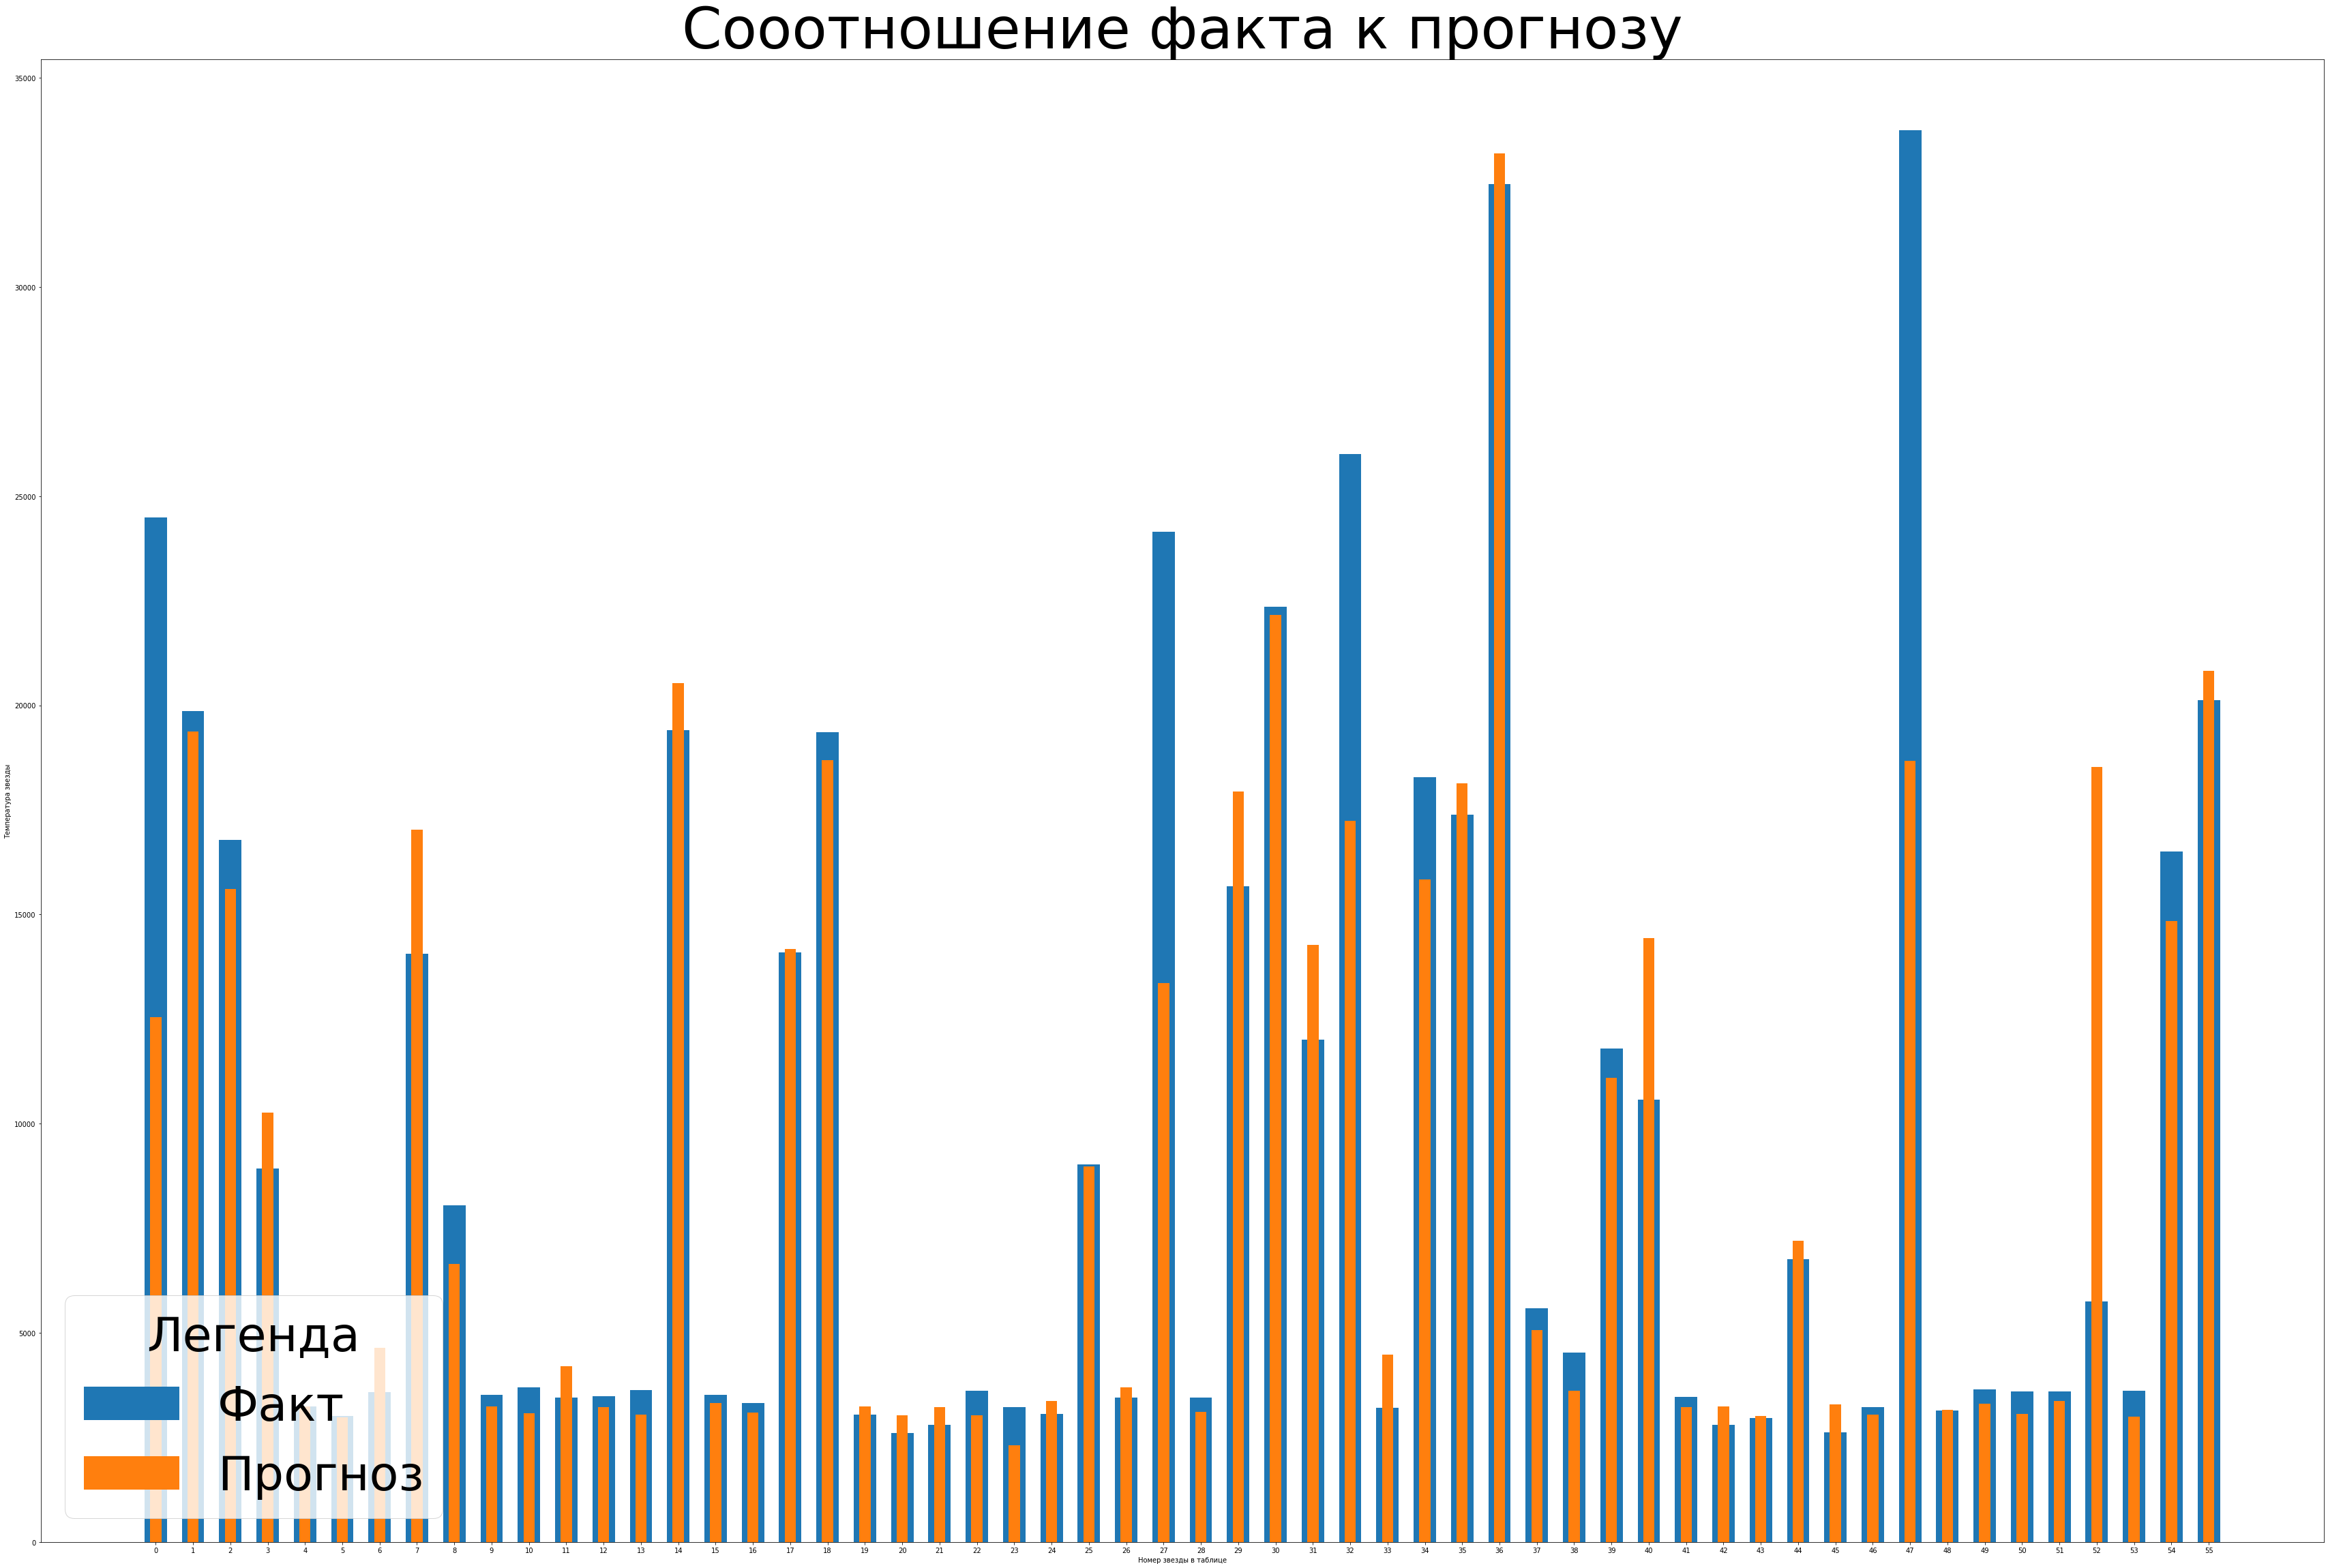

In [ ]:
fig = plt.figure()
fig.set_size_inches(60, 40)

fig,ax = plt.subplots()
fig.set_size_inches(60,40)

plt.rc('font', size=70) #controls default text size

у1 = pred_temp
y2 = y_test
x = np.arange(len(у1))

ax.set_xticks(x)
fact = ax.bar(x, y2, width = 0.6, label = 'Факт')
forecast = ax.bar(x, у1, width = 0.3, label = 'Прогноз')

ax.set_ylabel('Температура звезды')
ax.set_xlabel('Номер звезды в таблице')
ax.set_title('Сооотношение факта к прогнозу')
ax.legend(loc='lower left', title='Легенда')

plt.show()

Выводы:
- Хорошо поднять метрику помогло повышение числа нейронов в скрытом слое, причем в сторону их увеличения, надо будет позже исследовать этот метод более подробно, чтобы понять как эффективно подбирать гиперпараметры для обучения модели
- По качеству предсказаний, исходя из графика наибольшей точности модель достигает при предсказании небольших значений, с температурой до 5000 кельвинов, связано это скорее всего что именно эти данные представляют собой основную массу датасета, поэтому на них модель раотает лучше всего
- При установке колличества эпох на 10 000 до определенного момента метрика падает, но затем начинает переобучаться и метрика наоборот начинает расти и по видимому нейросеть переобучается

## Улучшение нейронной сети

Проведем обучение нейронной сети с перебором гиперпараметров, за основу возьмем предыдущую нейронную сеть, в качестве параметров для перебора, используем следующие

In [ ]:
pip install torch skorch scikit-learn

     |████████████████████████████████| 239 kB 1.0 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Создадим свой собственный оценьщик для проверки метрики RMSE по результатам работы модели
rmse = make_scorer(mean_squared_error,greater_is_better=False, squared=False)

In [ ]:
n_in_neurons = X_train.shape[1] # зададим количество нейронов
n_hidden_neurons_1 = 600
n_hidden_neurons_2 = 950
n_out_neurons = 1

class Net(nn.Module):
    '''
    Класс по созданию нейронной сети
    '''
    def __init__(self, dropout_rate=0.2):
        super().__init__()
        self.fc1 = torch.nn.Linear(X_train.shape[1], 600)
        self.fc2 = nn.Linear(600, 950)
        self.fc3 = nn.Linear(950, 1)
        self.relu1 = nn.LeakyReLU()
        self.relu2 = nn.LeakyReLU()
        self.relu3 = nn.LeakyReLU(negative_slope=0.7)
        self.dp1 = nn.Dropout(dropout_rate)
        self.dp2 = nn.Dropout(dropout_rate)

    def forward(self, batch):
        batch = self.fc1(batch)
        batch = self.relu1(batch)
        batch = self.dp1(batch)
        batch = self.fc2(batch)
        batch = self.relu2(batch)
        batch = self.dp2(batch)
        batch = self.fc3(batch)

        return self.relu3(batch)

#net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, dropout_rate)

#optimizer = torch.optim.Adam(net.parameters(), lr=1e-3) # создаем Adam оптимизатор

#loss = nn.MSELoss(reduction='sum') # В качестве функции потерь используем MSE

class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss(reduction='sum')
        eps = 1e-6
        loss = torch.sqrt(criterion(x, y) + eps)

        return loss


# create model with skorch
model = NeuralNetRegressor(
    Net,
    criterion=RMSELoss(),
    optimizer=torch.optim.Adam,
    max_epochs=2600,
    verbose=False
)

# define the grid search parameters
param_grid = {
    'batch_size': range(20, X_train.shape[0], 20),
    'module__dropout_rate': [0.0, 0.2, 0.4, 0.6, 0.8,]
}
grid = GridSearchCV(model, param_grid, scoring= rmse, n_jobs=-1, cv=3, verbose=True)
grid_result = grid.fit(X_train, y_train)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print(grid_result.best_score_, grid_result.best_params_)

#run
#model.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
-6266.349284 (1218.531212) with: {'batch_size': 20, 'module__dropout_rate': 0.0}
-4739.418620 (782.583828) with: {'batch_size': 20, 'module__dropout_rate': 0.2}
-4676.567952 (974.600274) with: {'batch_size': 20, 'module__dropout_rate': 0.4}
-4329.153483 (851.095210) with: {'batch_size': 20, 'module__dropout_rate': 0.6}
-4173.359619 (835.947218) with: {'batch_size': 20, 'module__dropout_rate': 0.8}
-7914.333496 (4738.308375) with: {'batch_size': 40, 'module__dropout_rate': 0.0}
-4869.708822 (485.254840) with: {'batch_size': 40, 'module__dropout_rate': 0.2}
-4661.945150 (495.729690) with: {'batch_size': 40, 'module__dropout_rate': 0.4}
-4216.930420 (739.658009) with: {'batch_size': 40, 'module__dropout_rate': 0.6}
-4026.784912 (772.779245) with: {'batch_size': 40, 'module__dropout_rate': 0.8}
-7618.428385 (4226.106810) with: {'batch_size': 60, 'module__dropout_rate': 0.0}
-5744.671712 (1053.738206) with: {'batch_size': 60, 'mo

Наилучший результат- 4004.977
Наилучшие гиперпараметры: 'batch_size'- 160,'module__dropout_rate'- 0.8

In [ ]:
# Гиперпараметры обучения:
n_in_neurons = X_train.shape[1] # зададим количество нейронов
n_hidden_neurons_1 = 600
n_hidden_neurons_2 = 950
n_out_neurons = 1
num_epochs = 2600 # количество эпох
batch_size = 160
learning_rate = 0.01
num_batches = ceil(len(X_train)/batch_size)
dropout_rate = 0.8

class Net(nn.Module):
    '''
    Класс по созданию нейронной сети
    '''
    def __init__(self, n_features, n, n1, n_out):
        super().__init__()
        self.fc1 = torch.nn.Linear(n_features, n)
        self.fc2 = nn.Linear(n, n1)
        self.fc3 = nn.Linear(n1, n_out)
        self.relu1 = nn.LeakyReLU()
        self.relu2 = nn.LeakyReLU()
        self.relu3 = nn.LeakyReLU(negative_slope=0.7)
        self.dp1 = nn.Dropout(dropout_rate)
        self.dp2 = nn.Dropout(dropout_rate)

    def forward(self, batch):
        batch = self.fc1(batch)
        batch = self.relu1(batch)
        batch = self.dp1(batch)
        batch = self.fc2(batch)
        batch = self.relu2(batch)
        batch = self.dp2(batch)
        batch = self.fc3(batch)

        return self.relu3(batch)

net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3) # создаем Adam оптимизатор

loss = nn.MSELoss(reduction='sum') # В качестве функции потерь используем MSE

for epoch in range(num_epochs):
    order = np.random.permutation(len(X_train))
    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size
        optimizer.zero_grad()


    batch_indexes = order[start_index:start_index+batch_size]
    X_batch = X_train[batch_indexes]
    y_batch = y_train[batch_indexes]

    preds = net.forward(X_train)

    loss_value = loss(preds, y_train)

    loss_value.backward()

    optimizer.step()

    if epoch % 10 == 0 or epoch == num_epochs - 1:
        net.eval()
        test_preds = net.forward(X_test).flatten()
        pred_temp = test_preds.detach().numpy()
        rmse = mean_squared_error(y_test, pred_temp, squared=False)
        print(rmse)

12679.645
12669.847
12646.545
12600.119
12516.549
12377.346
12160.639
11844.297
11409.949
10849.423
10173.827
9420.155
8639.827
7898.741
7275.9707
6821.6226
6529.878
6353.561
6241.7144
6159.6455
6087.2236
6015.8564
5943.652
5871.1494
5800.302
5732.113
5667.2705
5605.5244
5546.5947
5490.2676
5435.7114
5383.262
5333.38
5285.3687
5239.293
5194.7695
5151.854
5109.9756
5068.848
5029.3115
4991.5825
4954.8877
4919.063
4884.672
4851.522
4819.3574
4788.4375
4758.4014
4729.9067
4702.755
4676.375
4650.7466
4625.599
4600.9473
4577.576
4555.8853
4536.1406
4517.654
4499.151
4481.886
4465.0913
4449.169
4434.117
4419.996
4406.42
4393.566
4381.643
4370.2627
4359.551
4349.3057
4339.4775
4329.878
4320.3364
4309.945
4300.253
4290.442
4281.8354
4274.214
4266.4834
4258.6772
4250.6104
4243.4194
4236.953
4230.499
4224.1494
4217.627
4211.308
4205.444
4199.7773
4193.9517
4188.1943
4182.7676
4177.186
4171.698
4166.148
4160.6094
4155.3374
4150.369
4145.3164
4140.3853
4135.6626
4130.6187
4125.925
4121.3916
4116.59

Наименьшая метрика RMSE на тестовой выборке, с учетом подобранных параметров- 3885.2212

/opt/conda/lib/python3.9/site-packages/numpy/lib/stride_tricks.py:536: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
/opt/conda/lib/python3.9/site-packages/numpy/lib/stride_tricks.py:536: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
/opt/conda

<Figure size 4320x2880 with 0 Axes>

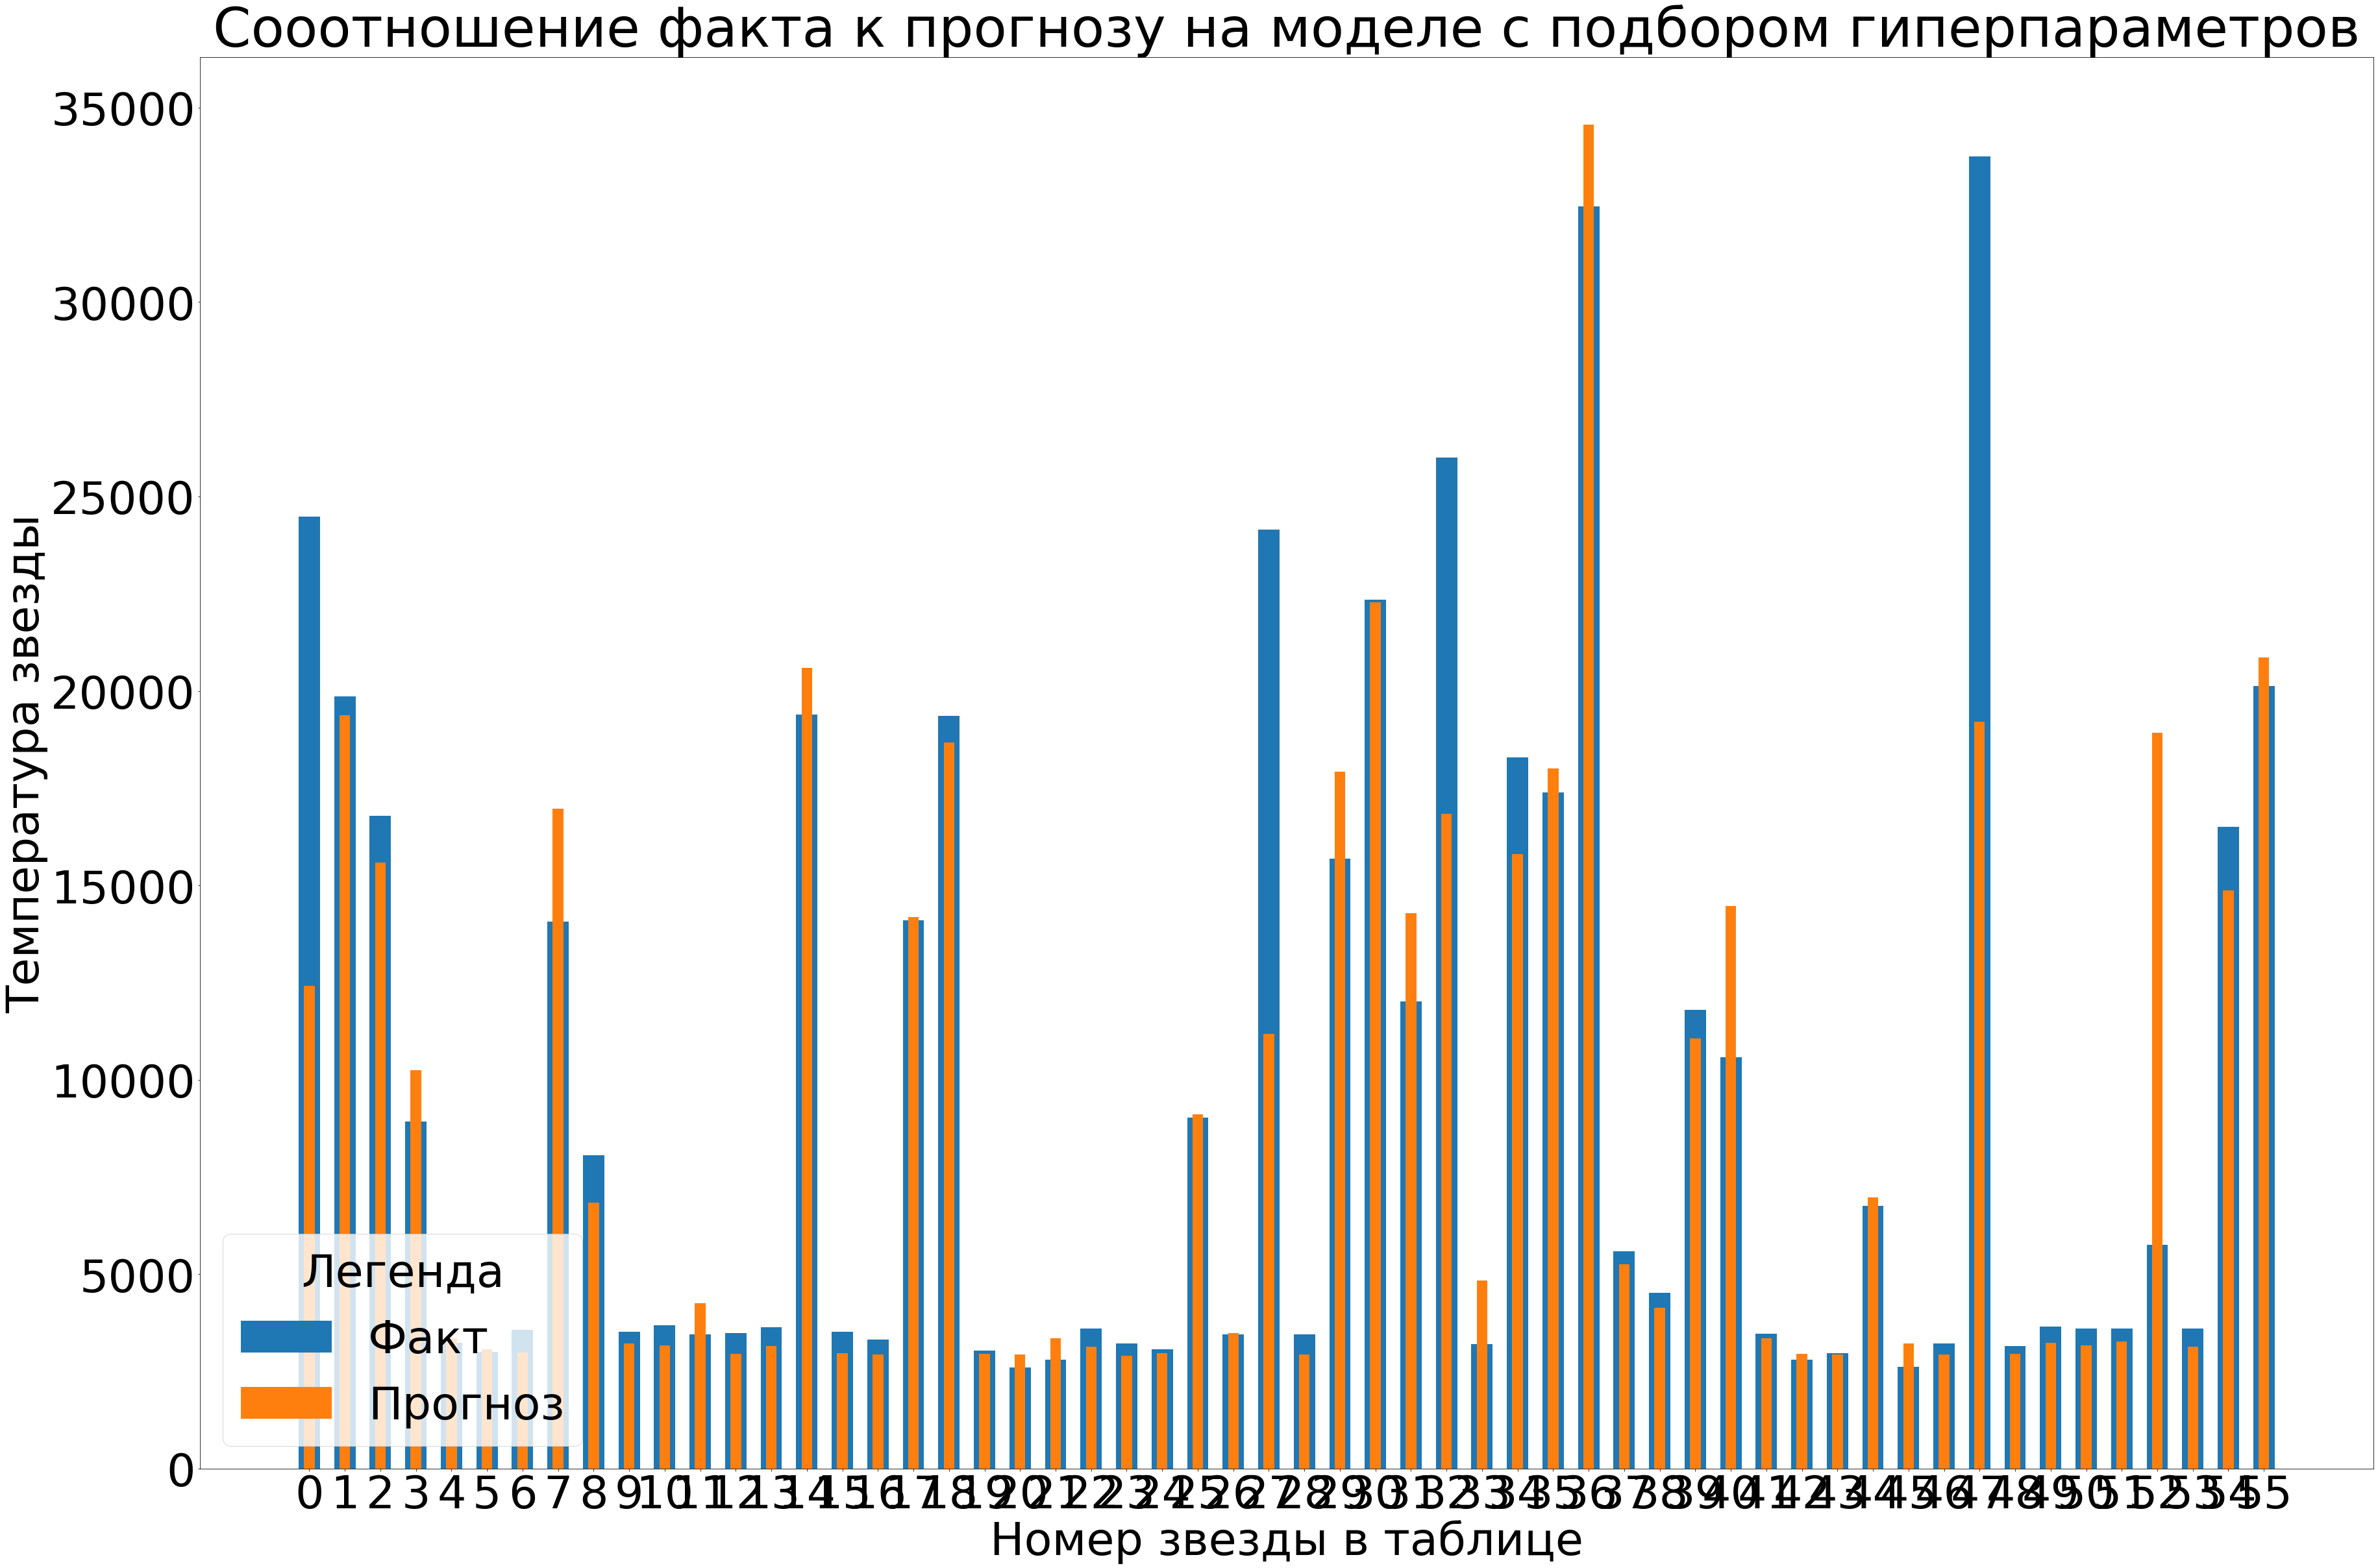

In [ ]:
fig = plt.figure()
fig.set_size_inches(60, 40)

fig,ax = plt.subplots()
fig.set_size_inches(60,40)

plt.rc('font', size=70) #controls default text size

у1 = pred_temp
y2 = y_test
x = np.arange(len(у1))

ax.set_xticks(x)
fact = ax.bar(x, y2, width = 0.6, label = 'Факт')
forecast = ax.bar(x, у1, width = 0.3, label = 'Прогноз')

ax.set_ylabel('Температура звезды')
ax.set_xlabel('Номер звезды в таблице')
ax.set_title('Сооотношение факта к прогнозу на моделе с подбором гиперпараметров')
ax.legend(loc='lower left', title='Легенда')

plt.show()

## Выводы

Вывод по итогу проекта:
1. Лучший результат при переборе гиперпараметров показала модель с размером батча= 160 и dropout_rate= 0.8
Что позволило получить на тестовой выборке метрику RMSE, равную 3885, однако к сожалению это не позволило улучшить результата baseline модели.
2. Baseline модель, использующая размер батча 100 и не использующая dropout, оказалась незначительно лучше модели с подбором гиперпарметров, показав на тестовой выборке метрику RMSE равную 3748
3. Согласно графику, обе модели ведут себя с данными довольно похоже, хорошо справляясь с предсказаниями температуры до 5000 кельвинов, так как эти данные представляют собой большую часть датасета
4. Для дальнейшего улучшения модели, стоит применить перебор и других гиперпараметров, например колличество эпох, а также laerning rate, что в перспективе способно дать еще более лучшие результаты, с точки зрения точности работы модели. А также, дополнительно расширить датасет, путем поиска доп данных с целевой метрикой свыше 5000 Кельвинов, что может помочь исправить дисбаланс классов.